In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm
from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

df = pd.read_csv("../data/processed/train.csv")
df["날짜"] = pd.to_datetime(df["날짜"])
df.rename(columns={"시간": "demand"}, inplace=True)

In [2]:
# 1차 차분 수행
df["demand_diff"] = df["demand"].diff()
df = df.dropna().reset_index(drop=True)


# 데이터 스케일링
features_to_scale = ["demand", "demand_diff"]
scaler = MinMaxScaler()
# fit_transform은 NumPy 배열을 반환
scaled_features = scaler.fit_transform(df[features_to_scale])

In [3]:
def create_multi_feature_sequences(input_data, look_back=12):
    X, y = [], []
    # input_data의 첫 번째 컬럼(수요량)을 예측 타겟으로 사용
    target_data = input_data[:, 0]
    for i in range(len(input_data) - look_back):
        # look_back 기간 동안의 다중 피처(수요량, 차분값)를 X로 사용
        X.append(input_data[i : (i + look_back), :])
        # 바로 다음 시점의 수요량(첫 번째 피처)을 y로 사용
        y.append(target_data[i + look_back])
    return np.array(X), np.array(y)

In [4]:
look_back = 30
X, y = create_multi_feature_sequences(scaled_features, look_back)

In [5]:
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float().view(-1, 1)

In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        # input_size: 피처의 개수 (수요량, 차분값 -> 2개)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [7]:
n_total = len(X_tensor)
n_backtest = 168
n_initial_train = n_total - n_backtest
batch_size = 64
num_epochs = 5
chunk_size = 56  # 한 번에 예측할 청크 사이즈

backtest_predictions_nested = []  # 리스트의 리스트 형태로 저장될 예측값

print(f"청크 단위 백테스팅을 시작합니다 (청크 사이즈: {chunk_size})")

for i in tqdm(range(0, n_backtest, chunk_size), desc="Backtesting Progress"):
    # ⭐ 1. 훈련 데이터셋을 점진적으로 업데이트
    train_end_idx = n_initial_train + i
    X_train = X_tensor[:train_end_idx]
    y_train = y_tensor[:train_end_idx]

    # ⭐ 2. 테스트 데이터셋 슬라이싱 로직 수정
    test_start_idx = train_end_idx
    test_end_idx = train_end_idx + chunk_size
    X_test = X_tensor[test_start_idx:test_end_idx]

    # DataLoader 생성
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(
        dataset=train_dataset, batch_size=batch_size, shuffle=True
    )

    # 모델 학습
    model = LSTMModel(input_size=2, hidden_size=50, num_layers=1, output_size=1)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    model.train()
    for epoch in range(num_epochs):
        for X_batch, y_batch in train_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # 예측 수행
    model.eval()
    with torch.no_grad():
        prediction = model(X_test)
        backtest_predictions_nested.append(prediction.squeeze().tolist())

청크 단위 백테스팅을 시작합니다 (청크 사이즈: 56)


Backtesting Progress:   0%|          | 0/3 [00:00<?, ?it/s]

백테스팅 결과 - 평균 절대 오차 (MAE): 1045.28


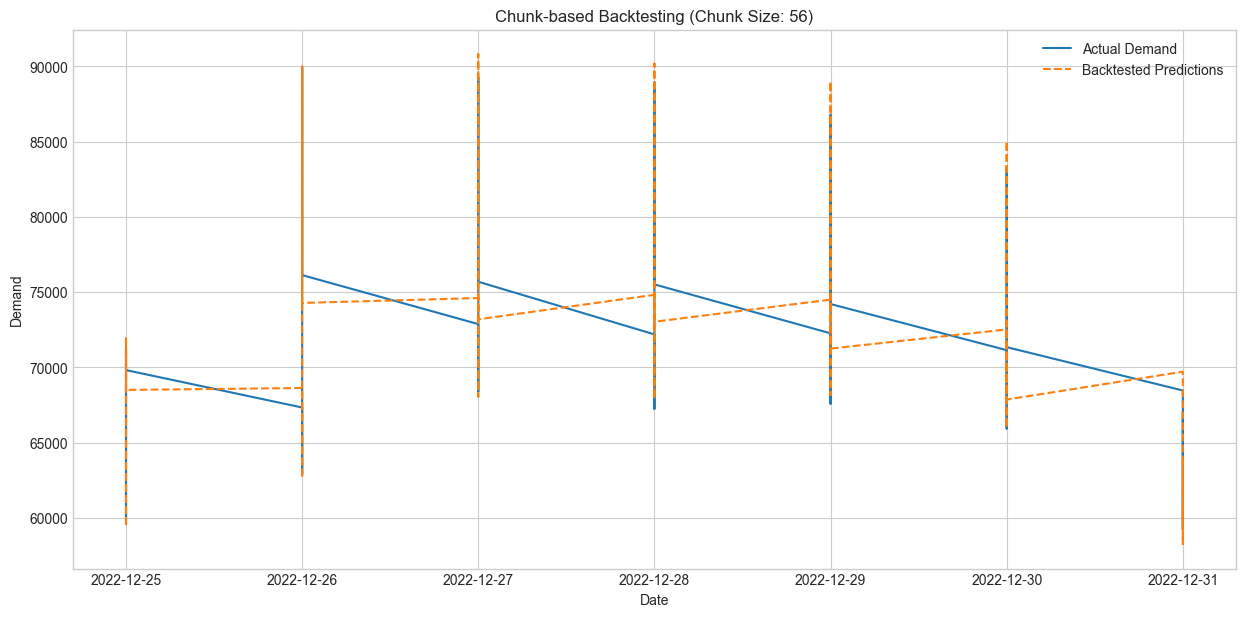

In [11]:
backtest_predictions_flat = [
    item for sublist in backtest_predictions_nested for item in sublist
]

# 스케일링 역변환
predictions_array = np.array(backtest_predictions_flat).reshape(-1, 1)
dummy_features = np.zeros((predictions_array.shape[0], len(features_to_scale) - 1))
combined_predictions = np.concatenate([predictions_array, dummy_features], axis=1)
inverse_predictions = scaler.inverse_transform(combined_predictions)[:, 0]

# 실제값 추출 (전체 백테스트 기간만큼)
actual_values = df["demand"].values[-len(inverse_predictions) :]

mae = mean_absolute_error(actual_values, inverse_predictions)
print(f"백테스팅 결과 - 평균 절대 오차 (MAE): {mae:.2f}")

# 시각화
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(15, 7))
plt.plot(
    df["날짜"].values[-len(actual_values) :],
    actual_values,
    label="Actual Demand",
    zorder=1,
)
plt.plot(
    df["날짜"].values[-len(inverse_predictions) :],
    inverse_predictions,
    label="Backtested Predictions",
    linestyle="--",
    zorder=2,
)
plt.title(f"Chunk-based Backtesting (Chunk Size: {chunk_size})")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.legend()
plt.show()

In [ ]:
model.